In [26]:
#this is the main file


#importing required libraries

from classes.constantsmd import *
from classes.gridmd import *
from classes.functionsmd import *
from numpy import sin, cos, deg2rad, matrix, size, invert, multiply, array, sqrt, ones, empty, sum, average, abs
from matplotlib.pyplot import plot

#import matplotlib.pyplot as plt
#from sympy import init_printing
#from mpl_toolkits.mplot3d import Axes3D
#import csv
#import pandas as pd
print("-----------start-----------")

-----------start-----------


In [2]:
N = N_xyz(100,6,6)
coor_0 = initialPos(N,ial)
xyz_grid = xyz_grid(coor_0[0], coor_0[1], coor_0[2])

In [3]:
x1, x2, x3 = xyz_grid[0][0][0][0], xyz_grid[1][0][0][0], xyz_grid[2][0][0][0]

In [4]:
forceLJ(ial, xyz_grid[0][0][0][0], xyz_grid[1][0][0][0])

-1.4138322080137485e+20

In [5]:
LJ(ial)

1200493294.8065505

In [42]:
avagadro = 6.023e-23
ial = 1.02e-10 #interatomic length
epsilon = 0.5* 1.6e-19 #1.5 #dummy value
sigma = 2.85e-10 #dummy value
vel = 1000 #velocity per step
acc = 0 #acceleration
ts = 5e-9 #timestep ex: 0.005 nano seconds as 0.005e-9
N_steps = 100

-5.04899999995e-09 	 2.83625090236e-31
-5.0489999999e-09 	 2.21582105662e-33
-5.04899999985e-09 	 1.29686829867e-34
-5.0489999998e-09 	 1.73111021578e-35
-5.04899999975e-09 	 3.63040125766e-36
-5.0489999997e-09 	 1.0131783643e-36
-5.04899999965e-09 	 3.44396223182e-37
-5.0489999996e-09 	 1.35242986205e-37
-5.04899999955e-09 	 5.92989624532e-38
-5.0489999995e-09 	 2.83625099257e-38
-5.04899999945e-09 	 1.45544522265e-38
-5.0489999994e-09 	 7.91545599442e-39
-5.04899999935e-09 	 4.52002872815e-39
-5.0489999993e-09 	 2.6905955004e-39
-5.04899999925e-09 	 1.65999143794e-39
-5.0489999992e-09 	 1.05658583206e-39
-5.04899999915e-09 	 6.9119758466e-40
-5.0489999991e-09 	 4.63273145075e-40
-5.04899999905e-09 	 3.17299549094e-40
-5.048999999e-09 	 2.21582109186e-40
-5.04899999895e-09 	 1.57474268103e-40
-5.0489999989e-09 	 1.13706658202e-40
-5.04899999885e-09 	 8.33009222466e-41
-5.0489999988e-09 	 6.18395000474e-41
-5.04899999875e-09 	 4.64691363609e-41
-5.0489999987e-09 	 3.53127244867e-41
-5.

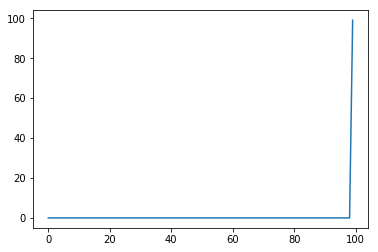

In [45]:
vpos = empty(N_steps)
old = x1
for i in range(N_steps-1):
    #print(verlet_pos(old,i*ts,ts,acc),"\n")
    vpos[i]=verlet_pos(old,i*ts,ts,forceLJ(vpos[i+1]-vpos[i],vpos[i],vpos[i+1])/avagadro)
    old = vpos[i]
    
    print(vpos[i],'\t',forceLJ(vpos[i+1]-vpos[i],vpos[i],vpos[i+1])/avagadro)
plot(range(N_steps),vpos)

In [8]:
print("------------end------------")

------------end------------
